In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from sklearn.ensemble import RandomForestClassifier
import pickle


In [3]:
df = pd.read_csv("../data/processed_stroke_data.csv")

X = df.drop("stroke", axis=1)
y = df["stroke"]

categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [5]:
scaler = pickle.load(open("../pipelines/scaler.pkl", "rb"))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_scaled, y_train
)


In [7]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}


In [8]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="recall",   # VERY IMPORTANT for medical use
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [9]:
best_model = grid_search.best_estimator_
best_model


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-Score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob))


Accuracy : 0.8522504892367906
Precision: 0.1564625850340136
Recall   : 0.46
F1-Score : 0.233502538071066
ROC-AUC  : 0.7935185185185186


In [11]:
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)


age                            0.431617
ever_married_Yes               0.101112
bmi                            0.077913
avg_glucose_level              0.073935
Residence_type_Urban           0.060348
gender_Male                    0.048705
id                             0.046573
hypertension                   0.029960
work_type_Private              0.027229
smoking_status_never smoked    0.026231
dtype: float64

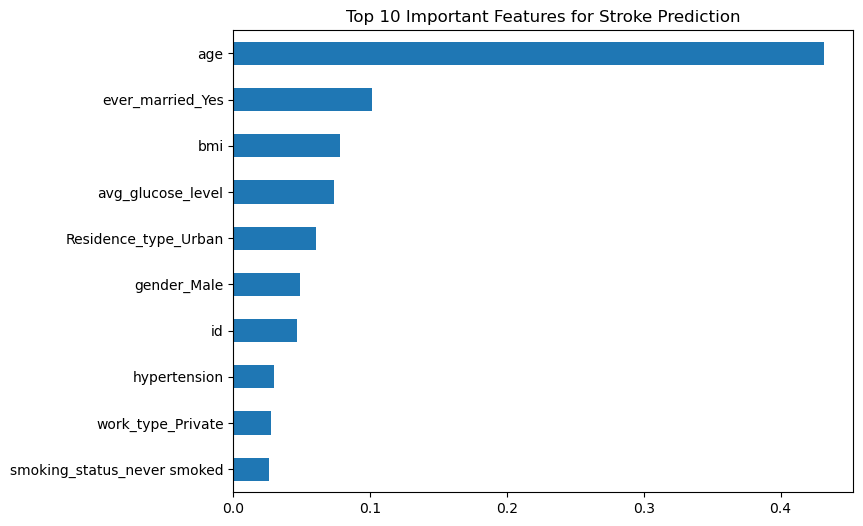

In [12]:
plt.figure(figsize=(8,6))
feature_importance.head(10).plot(kind="barh")
plt.title("Top 10 Important Features for Stroke Prediction")
plt.gca().invert_yaxis()
plt.show()


In [13]:
pickle.dump(best_model, open("../models/final_stroke_model.pkl", "wb"))
